In [1]:
import networkx as nx
import pandas as pd
import stellargraph as sg
import graphnets
from graphnets import gcn_pipeline, graphsage_pipeline

**Data Loading**

In [2]:
network = pd.read_csv('data/bio-pathways-network.csv')
graph = nx.from_pandas_edgelist(network, 'Gene ID 1', 'Gene ID 2')

In [3]:
multi_diseases = pd.read_csv('data/simple-all-proteins.csv', index_col=0)
binary_diseases = pd.read_csv('data/binary-classes.csv', index_col=0)
multi_only_diseases = pd.read_csv('data/simple-diseased-proteins.csv', index_col=0)

**GCN**

Multiclassification over Full Network with GCN

In [7]:
nodes = set(graph.nodes())
drop_rows = []
for n in simple_diseases.index:
    if n not in nodes:
        drop_rows.append(n)
node_multi_diseases = simple_diseases.drop(drop_rows)

In [8]:
G = sg.StellarGraph(graph, node_features=node_multi_diseases)
G.info()

<ipython-input-8-87ae3ee9e0d6>:1: DeprecationWarning: Constructing a StellarGraph directly from a NetworkX graph has been replaced by the `StellarGraph.from_networkx` function
  G = sg.StellarGraph(graph, node_features=node_multi_diseases)


'StellarGraph: Undirected multigraph\n Nodes: 21557, Edges: 342353\n\n Node types:\n  default: [21557]\n    Features: float32 vector, length 10\n    Edge types: default-default->default\n\n Edge types:\n    default-default->default: [342353]\n        Weights: all 1 (default)\n        Features: none'

Array shapes:
 train = (4311, 10)
 val = (8623, 10)
 test = (8623, 10)
Using GCN (local pooling) filters...
Training...
1/1 [==============================] - 0s 3ms/step - loss: 0.4626 - acc: 0.1252 - f1_m: 0.2592 - precision_m: 0.4622 - recall_m: 0.1801

Test Set Metrics:

loss: 0.4626

acc: 0.1252

f1_m: 0.2592

precision_m: 0.4622

recall_m: 0.1801


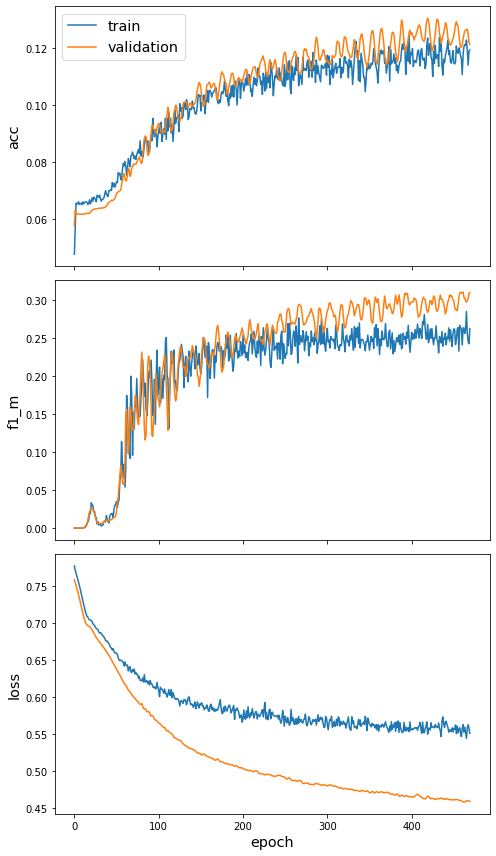

In [9]:
gcn_pipeline(G, node_multi_diseases, layer_sizes=[32, 32])

Binary Classification of Presence of Disease with GCN

In [101]:
nodes = set(graph.nodes())
drop_rows = []
for n in binary_diseases.index:
    if n not in nodes:
        drop_rows.append(n)
bin_nodes = binary_diseases.drop(drop_rows)

In [102]:
bG = sg.StellarGraph(graph, node_features=bin_nodes)
bG.info()

<ipython-input-102-472593fd28b8>:1: DeprecationWarning: Constructing a StellarGraph directly from a NetworkX graph has been replaced by the `StellarGraph.from_networkx` function
  bG = sg.StellarGraph(graph, node_features=bin_nodes)


'StellarGraph: Undirected multigraph\n Nodes: 21557, Edges: 342353\n\n Node types:\n  default: [21557]\n    Features: float32 vector, length 1\n    Edge types: default-default->default\n\n Edge types:\n    default-default->default: [342353]\n        Weights: all 1 (default)\n        Features: none'

Array shapes:
 train = (4311, 1)
 val = (8623, 1)
 test = (8623, 1)
Using GCN (local pooling) filters...
Training...
1/1 [==============================] - 0s 2ms/step - loss: 2.9972e-08 - acc: 0.2514 - f1_m: 0.4018 - precision_m: 0.2514 - recall_m: 1.0000

Test Set Metrics:

loss: 0.0000

acc: 0.2514

f1_m: 0.4018

precision_m: 0.2514

recall_m: 1.0000


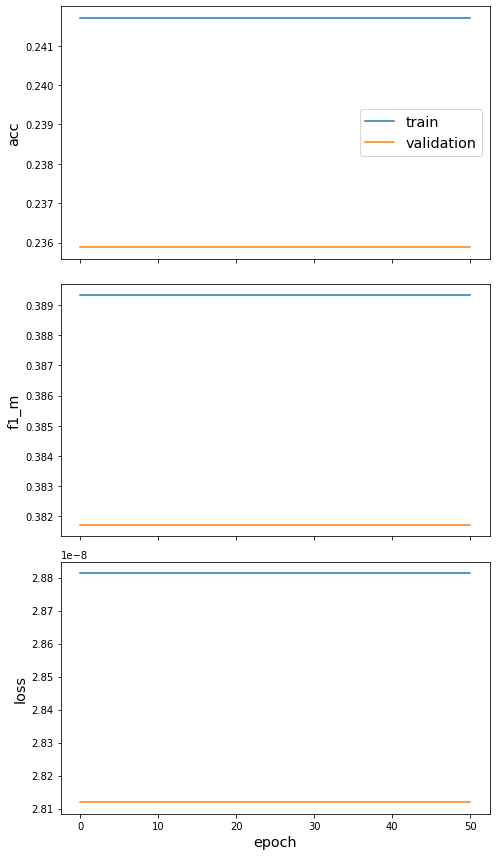

In [103]:
gcn_pipeline(bG, bin_nodes)

Multiclassification of Diseased Network with GCN

In [130]:
dis_graph = nx.read_gml('networks/diseased-ppi')
dis_graph = nx.relabel_nodes(dis_graph, lambda x: int(x), copy=False)

In [131]:
nodes = set(dis_graph.nodes())
drop_rows = []
for n in multi_only_diseases.index:
    if n not in nodes:
        drop_rows.append(n)
dis_nodes_multi = multi_only_diseases.drop(drop_rows)

In [132]:
dG = sg.StellarGraph(dis_graph, node_features=dis_nodes_multi)
dG.info()

<ipython-input-132-3024e44d78ef>:1: DeprecationWarning: Constructing a StellarGraph directly from a NetworkX graph has been replaced by the `StellarGraph.from_networkx` function
  dG = sg.StellarGraph(dis_graph, node_features=dis_nodes_multi)


'StellarGraph: Undirected multigraph\n Nodes: 5029, Edges: 65674\n\n Node types:\n  default: [5029]\n    Features: float32 vector, length 30\n    Edge types: default-default->default\n\n Edge types:\n    default-default->default: [65674]\n        Weights: all 1 (default)\n        Features: none'

Array shapes:
 train = (1005, 30)
 val = (2012, 30)
 test = (2012, 30)
Using GCN (local pooling) filters...
Training...
1/1 [==============================] - 0s 2ms/step - loss: 5.1133 - acc: 0.3429 - f1_m: 5.5944e-04 - precision_m: 0.5000 - recall_m: 2.7988e-04

Test Set Metrics:

loss: 5.1133

acc: 0.3429

f1_m: 0.0006

precision_m: 0.5000

recall_m: 0.0003


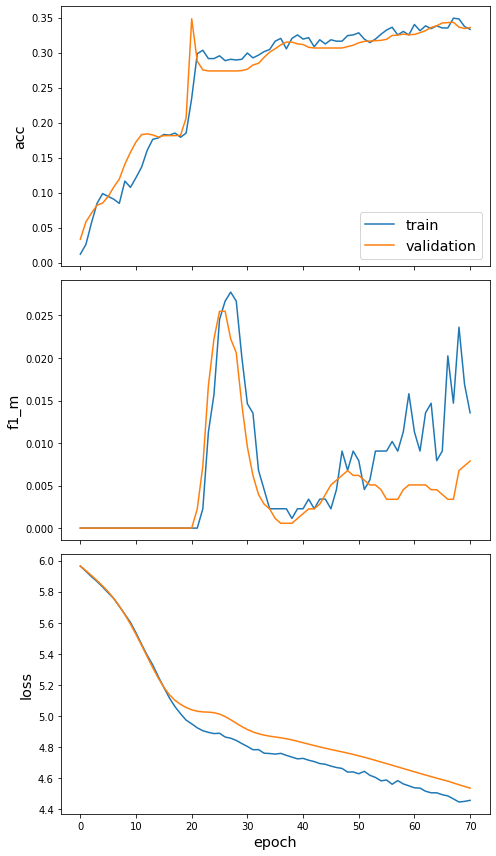

In [133]:
gcn_pipeline(dG, dis_nodes_multi, layer_sizes=[32,32])

**GraphSAGE**

Multiclassification over Full Network with GraphSAGE

Array shapes:
 train = (12934, 30)
 val = (4311, 30)
 test = (4312, 30)
87/87 [==============================] - 2s 19ms/step - loss: 1.1322 - acc: 0.0638

Test Set Metrics:
	loss: 1.1322
	acc: 0.0638


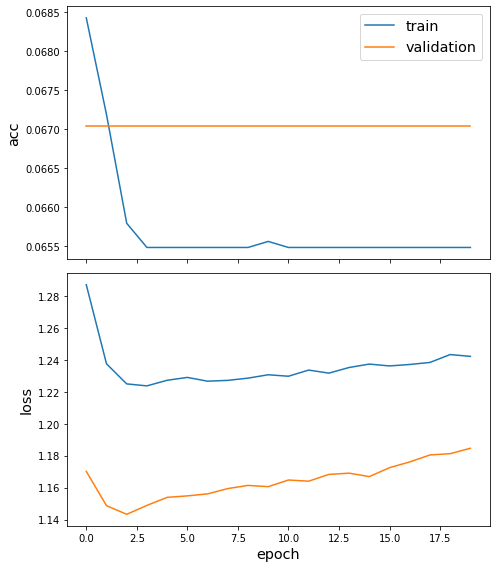

In [187]:
graphsage_pipeline(G, node_multi_diseases)

Binary Classification over Full Network with GraphSAGE

Array shapes:
 train = (12934, 1)
 val = (4311, 1)
 test = (4312, 1)
87/87 [==============================] - 2s 19ms/step - loss: 0.0000e+00 - acc: 0.2474

Test Set Metrics:
	loss: 0.0000
	acc: 0.2474


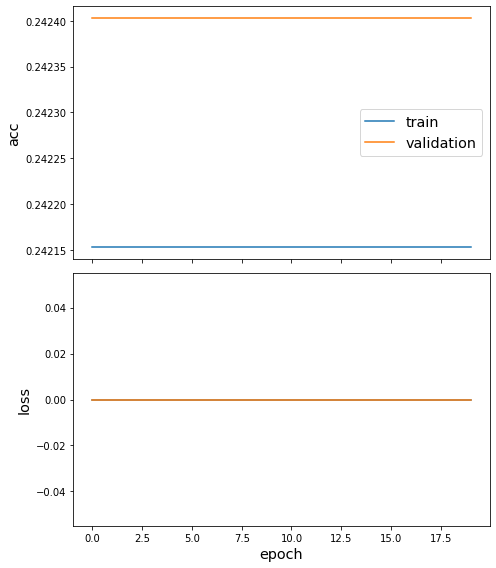

In [188]:
graphsage_pipeline(bG, bin_nodes)

Multiclassification over Diseased Network with GraphSAGE

Array shapes:
 train = (3017, 30)
 val = (1006, 30)
 test = (1006, 30)
21/21 [==============================] - 0s 18ms/step - loss: 5.0096 - acc: 0.2704

Test Set Metrics:
	loss: 5.0096
	acc: 0.2704


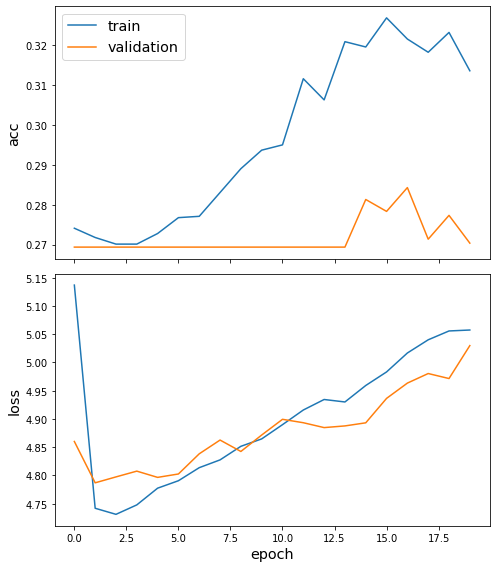

In [189]:
graphsage_pipeline(dG, dis_nodes_multi)